In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from matplotlib import pyplot as plt


from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
from torch.optim.adam import Adam

from graphnet.constants import EXAMPLE_DATA_DIR, EXAMPLE_OUTPUT_DIR
from graphnet.data.constants import FEATURES, TRUTH
from graphnet.models import StandardModel
from graphnet.models.detector.prometheus import Prometheus
from graphnet.models.gnn import DynEdge
from graphnet.models.graph_builders import KNNGraphBuilder
from graphnet.models.task.reconstruction import EnergyReconstruction
from graphnet.training.callbacks import ProgressBar, PiecewiseLinearLR
from graphnet.training.loss_functions import LogCoshLoss
from graphnet.training.utils import make_train_validation_dataloader
from graphnet.utilities.argparse import ArgumentParser
from graphnet.utilities.logging import Logger


graphnet [MainProcess] WARNING  2023-05-03 16:50:16 - has_icecube_package - `icecube` not available. Some functionality may be missing.


## Define Settings

In [9]:
plot_dir = 'plots/'
data_dir = 'data/'

for directory in [plot_dir, data_dir]:
    if not os.path.exists(directory):
        print('Creating plot directory:', directory)
        os.makedirs(directory)

Creating plot directory: data/


In [3]:
db_file = '/net/big-tank/POOL/users/pgutjahr/data/data/graphnet/20904_labels.db'

wandb = False
config = {
    "path": db_file,
    "pulsemap": 'SRTInIcePulses',
    "batch_size": 16,
    "num_workers": 22,
    'truth_table': 'LabelsDeepLearning',
    "target": 'DNNLabel_TotalDepositedEnergy',
    "early_stopping_patience": None,
    "fit": {
        "gpus": 1,
        "max_epochs": 1,
    },
}


#### Define Features and Labels

In [4]:
from graphnet.models.detector.icecube import IceCube86

features = FEATURES.ICECUBE86

class TRUTH:
    """Namespace for standard names working with `I3TruthExtractor`."""

    ICECUBE86 = [
        "DNNLabel_TotalDepositedEnergy",
        # "energy",
        # "energy_track",
        # "position_x",
        # "position_y",
        # "position_z",
        # "azimuth",
        # "zenith",
        # "pid",
        # "elasticity",
        # "sim_type",
        # "interaction_type",
        # "interaction_time",  # Added for vertex reconstruction
        # "inelasticity",
        # "stopped_muon",
    ]

truth = TRUTH.ICECUBE86

#### Create Data Loaders

In [5]:
(
    training_dataloader,
    validation_dataloader,
) = make_train_validation_dataloader(
    config["path"],
    None,
    config["pulsemap"],
    features,
    truth,
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
    truth_table=config['truth_table'],
)

graphnet [MainProcess] INFO     2023-05-03 16:50:17 - StringSelectionResolver.__init__ - Writing log to logs/graphnet_20230503-165017.log


#### Build Model

In [6]:
detector = IceCube86(
    graph_builder=KNNGraphBuilder(nb_nearest_neighbours=8),
)
gnn = DynEdge(
    nb_inputs=detector.nb_outputs,
    global_pooling_schemes=["min", "max", "mean", "sum"],
)
task = EnergyReconstruction(
    hidden_size=gnn.nb_outputs,
    target_labels=config["target"],
    loss_function=LogCoshLoss(),
    transform_prediction_and_target=torch.log10,
)
model = StandardModel(
    detector=detector,
    gnn=gnn,
    tasks=[task],
    optimizer_class=Adam,
    optimizer_kwargs={"lr": 1e-03, "eps": 1e-03},
    scheduler_class=PiecewiseLinearLR,
    scheduler_kwargs={
        "milestones": [
            0,
            len(training_dataloader) / 2,
            len(training_dataloader) * config["fit"]["max_epochs"],
        ],
        "factors": [1e-2, 1, 1e-02],
    },
    scheduler_config={
        "interval": "step",
    },
)

#### Train Model

In [7]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=config["early_stopping_patience"],
    ),
    ProgressBar(),
]

model.fit(
    training_dataloader,
    validation_dataloader,
    callbacks=callbacks,
    logger=wandb_logger if wandb else None,
    #distribution_strategy="ddp_notebook",
    distribution_strategy=None,
    **config["fit"],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name      | Type       | Params
-----------------------------------------
0 | _detector | IceCube86  | 0     
1 | _gnn      | DynEdge    | 1.4 M 
2 | _tasks    | ModuleList | 129   
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.529     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


#### Get Predictions

In [10]:
additional_attributes = model.target_labels
assert isinstance(additional_attributes, list)  # mypy

results = model.predict_as_dataframe(
    validation_dataloader,
    additional_attributes=additional_attributes + ["event_no"],
)

graphnet [MainProcess] INFO     2023-05-03 17:03:38 - StandardModel.predict_as_dataframe - Column names for predictions are: 
 ['energy_pred']


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

#### Save predictions and model to file

In [14]:
db_name = config['path'].split("/")[-1].split(".")[0]
path = os.path.join(data_dir, db_name, 'test_run')
os.makedirs(path, exist_ok=True)

results.to_csv(f"{path}/results.csv")
model.save_state_dict(f"{path}/state_dict.pth")
model.save(f"{path}/model.pth")

graphnet [MainProcess] INFO     2023-05-03 17:09:02 - StandardModel.save_state_dict - Model state_dict saved to data/20904_labels/test_run/state_dict.pth
graphnet [MainProcess] INFO     2023-05-03 17:09:04 - StandardModel.save - Model saved to data/20904_labels/test_run/model.pth


#### Plot Results

In [16]:
results

,energy_pred,DNNLabel_TotalDepositedEnergy,event_no
0,47.939583,15.983420,61269.0
1,289.935974,103.907875,131479.0
2,2025.529297,3945.905518,115616.0
3,194.007401,183.664627,17797.0
4,304.647583,344.980286,71741.0
...,...,...,...
55684,868.400269,822.928711,80601.0
55685,112.659836,376.347321,43454.0
55686,206.380707,1832.363647,82079.0
55687,430.585815,324.949219,119082.0


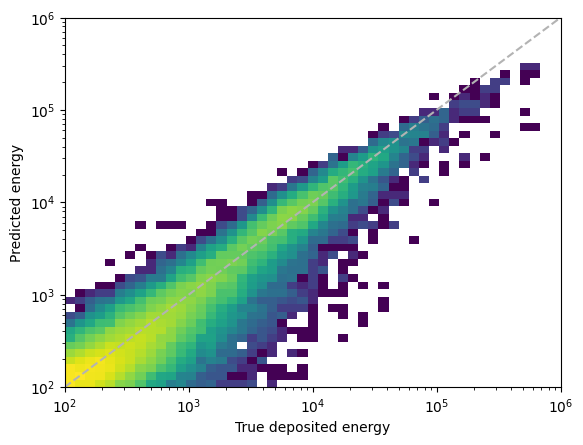

In [25]:
import numpy as np
import matplotlib

fig, ax = plt.subplots()

bins = (np.logspace(2, 6, 50), np.logspace(2, 6, 50))

ax.hist2d(
    results['DNNLabel_TotalDepositedEnergy'],
    results['energy_pred'], 
    norm=matplotlib.colors.LogNorm(),
    bins=bins,
)
ax.plot(bins[0], bins[0], ls='--', color='0.7')
ax.set_xlabel('True deposited energy')
ax.set_ylabel('Predicted energy')
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(
    os.path.join(plot_dir, 'correlation_TotalDepositedEnergy.png'), 
    dpi=100,
)
